<a href="https://colab.research.google.com/github/robinmollah/16guti/blob/master/SignPin%5BRobin%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ipycanvas

     |████████████████████████████████| 253 kB 5.1 MB/s 


In [3]:
!pip install ipywidgets

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
import json
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [6]:
from ipywidgets import interact, interactive, HBox, VBox
import ipywidgets as widgets

In [7]:
from ipycanvas import Canvas, hold_canvas


In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
with open('./drive/MyDrive/data.json', 'r') as oldDataFile:
  oldData = json.loads(oldDataFile.read())

In [10]:
canvas = Canvas(width=600, height=300)
canvas.layout.width = f'{canvas.width}px'
canvas.layout.height = f'{canvas.height}px'

In [11]:
byNickname = {}

for signature in oldData['signatures']:
  nickname = signature['nickname']

  if nickname not in byNickname:
    byNickname[nickname] = []

  byNickname[nickname].append(signature['data'])

In [12]:
def rotationMatrix(theta = np.pi / 2):
  cos, sin = np.cos(theta), np.sin(theta)

  return np.array(
    (
      (cos, -sin),
      (sin,  cos)
    )
  )

In [13]:
def oldDataArray(nickname, index):
  basicArray = np.array([
          (row['x'], row['y'], row['ti'], row['ty'])
          for row in byNickname[nickname][index]
  ])

  tyCount = 0
  tys = basicArray[:, 3]
  lastTy = tys[0]

  for i in range(1, len(tys)):
    ty = tys[i]

    if lastTy != ty:
      tyCount += 1
      tys[i - 1] = tyCount

    tys[i] = tyCount
    lastTy = ty

  basicArray[:, 3] = tys

  rotate90 = rotationMatrix()
  R = rotate90

  basicArray[:, 0:2] = basicArray[:, 0:2] @ R

  xCoords = basicArray[:, 0]
  yCoords = basicArray[:, 1]

  # Calculate the gradient of straightline of best fit & take x-axis gradient.
  incline = np.polyfit(xCoords, yCoords, 1)[0]

  # Calculate Radians from gradient and take negative for straightening transform.
  inclineRadians = np.arctan(incline)*1

  straightenR = rotationMatrix(inclineRadians)
  basicArray[:, 0:2] = basicArray[:, 0:2] @ straightenR

  w, h = basicArray[:, 0:2].max(axis = 0) - basicArray[:, 0:2].min(axis = 0)
  ratio = w/h

  normalizeTillColumn = 4
  basicArray[:, 0:normalizeTillColumn] = basicArray[:, 0:normalizeTillColumn] - basicArray[:, 0:normalizeTillColumn].min(axis = 0)
  basicArray[:, 0:normalizeTillColumn] = basicArray[:, 0:normalizeTillColumn] / basicArray[:, 0:normalizeTillColumn].max(axis = 0)

  return (basicArray, ratio)

tn=99
new_data=[[0.99607 0.93453 1.      1.     ]
 [0.40529 0.73502 0.5     0.     ]]
old_data=[[0.12365285 0.93001063 0.         0.        ]
 [0.09927301 0.87798401 0.02897259 0.        ]]


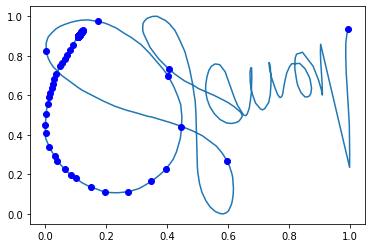

In [17]:
def midTime(data, n):
  tis = data[:, 2]
  given_ti = n
  end_point = np.searchsorted(tis, given_ti)
  end_point_vti = data[end_point, 2]
  start_point_vti = data[end_point - 1, 2]
  start_d_point = data[end_point-1];
  end_d_point = data[end_point]
  div = (given_ti - start_point_vti) / (end_point_vti - start_point_vti)
  new_point_x = div * start_d_point[0] + (1-div) * end_d_point[0]
  new_point_y = div * start_d_point[1] + (1-div) * end_d_point[1]
  
  new_point = [new_point_x, new_point_y, given_ti, start_d_point[3]]
  new_point = [round(x, 5) for x in new_point]
  return new_point


data, ratio = oldDataArray('OMRAN', 0)
tmp = midTime(data, 0.1)
# p_data
# data
plt.plot(data[:,0], data[:,1])
# plt.plot(p_data[:,0], p_data[:,1], 'bo')
# plt.plot(tmp[0], tmp[1], 'ro')
t_data = np.array([ midTime(data, 1.0 / x) for x in range(1,100)])
plt.plot(t_data[:,0], t_data[:,1], 'bo')
print(f'tn={len(t_data)}')
print(f'new_data={t_data[:2]}')
print(f'old_data={data[:2]}')
# t_data, data

In [ ]:
def normalizedByTime(data):
  return data;

nickname = "OMRAN"
index = 0
data, ratio = oldDataArray(nickname, index)
data.size

In [ ]:
def drawExtendedEdge(canvas, data, i):
  xi, yi, tii, peni = data[i]
  xj, yj, tij, penj = data[i + 1]
  magnitude = np.sqrt((xj - xi)**2 + (yj - yi) ** 2)
  slope = (yj - yi) / (xj - xi)
  c_val = yj - (slope * xj)
  direction = np.arctan((yj-yi)/(xj-xi))
  unit_vec = [xj - xi, yj - yi] / magnitude
  unit_vec = unit_vec * 0.08
  xj = xj + unit_vec[0]
  yj = slope * xj + c_val
  return xj, yj
  


In [ ]:
def scaleDown(p1, p2):
  p1x, p1y = p1
  p2x, p2y = p2
  p3x = (0.5 * p1x) + (0.5 * p2x)
  p3y = (0.5 * p1y) + (0.5 * p2y)
  return (p3x, p3y)

In [ ]:
nicknameSelector = widgets.Dropdown(
    options=tuple(byNickname.keys()),
    description='Nicknames: ',
)

signatureSelector = widgets.Dropdown(
    options=tuple(range(0, len(byNickname[nicknameSelector.value]))),
    description='Sign: ',
)

speedSelector = widgets.FloatSlider(
    value=1,
    min=0.3,
    max=10.0,
    description='Speed (s): ',
)

animateButton = widgets.Button(
    description='Animate'
)

def render(animate = False):
  canvas.clear()

  nickname = nicknameSelector.value
  index = int(signatureSelector.value)

  data, ratio = oldDataArray(nickname, index)
  data = data[7:14]
  # calculate gradient

  # data = normalizedByTime(data);

  if ratio > (canvas.width / canvas.height):
    width = canvas.width
    height = canvas.width / ratio
    yOffset = (canvas.height - height) / 2
    xOffset = 0

  else:
    height = canvas.height
    width = height * ratio
    yOffset = 0
    xOffset = (canvas.width - width) / 2


  with hold_canvas(canvas):
    for i in range(len(data) - 1):
      xi, yi, tii, peni = data[i]
      xj, yj, tij, penj = data[i + 1]
      magnitude = np.sqrt((xj - xi)**2 + (yj - yi) ** 2)
      slope = (yj - yi) / (xj - xi)
      c_val = yj - (slope * xj)
      direction = np.arctan((yj-yi)/(xj-xi))
      unit_vec = [xj - xi, yj - yi] / magnitude
      canvas.stroke_style = f'hsl({tii * 27000}, 100%, 50%)';
      canvas.font = '15px serif'
      # print(f'{i} - ti={tii}, m=({slope}) delT={tij-tii}')
      # print(f'{unit_vec}')
      # canvas.stroke_text(f'm=({slope}) delT={tij-tii} dir={np.degrees(direction)}', 10, 32 + 32 * i)
      canvas.begin_path()
      canvas.stroke_style = f'hsl({tii * 5100}, 100%, 50%)';

      canvas.move_to(
          xOffset + xi * width,
          yOffset + yi * height
      )

      
      scaled_down_x, scaled_down_y = scaleDown((xi, yi), (xj, yj));
      data[i+1] = scaled_down_x , scaled_down_y, tij, penj
      print(f'{scaled_down_x} {scaled_down_y} {xj} {yj}');
      canvas.line_to(
          xOffset + scaled_down_x * width,
          yOffset + scaled_down_y * height
      )


      # canvas.move_to(
      #     xOffset + 10 + xi * width,
      #     yOffset + 10 + yi * height
      # )

      # canvas.line_to(
      #     xOffset + 10 + xj * width,
      #     yOffset + 10 + yj * height
      # )

      extended_x, extended_y = drawExtendedEdge(canvas, data, i);
      canvas.line_to(
          xOffset + extended_x * width,
          yOffset + extended_y * height
      )
      
      canvas.stroke()
      canvas.close_path()

      if animate:
        canvas.sleep(
            float(speedSelector.value) * 1000 * (tij - tii)
        )


def chooseNickname(nickname):
  signatureSelector.options = tuple(range(0, len(byNickname[nickname])))
  signatureSelector.value = 0

def chooseSignature(index):
  render()

def animate(_):
  render(True)


nicknameSelectorInteractive = interactive(chooseNickname, nickname = nicknameSelector)
signatureSelectorInteractive = interactive(chooseSignature, index = signatureSelector)
animateButton.on_click(animate)

VBox([
      HBox([nicknameSelectorInteractive, signatureSelectorInteractive, speedSelector, animateButton]),
      canvas
])